# Statistical Learning Assignment

>***Name***: Matheus Felipe Eduardo Barbosa  
>***Student ID***: XXXXXXXXXX  

## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score,accuracy_score,auc,roc_curve,f1_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(7,7)})

/home/matheusbarbosa/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## The Dataset - Koi Data

In [2]:
data = pd.read_csv('koi_data.csv')
data.head(3)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276


In [3]:
X = data.drop(['koi_disposition','kepoi_name'], axis=1).values
y_raw = data[['koi_disposition']].values
X[0],y_raw[0]

(array([ 9.488040e+00,  1.460000e-01,  2.957500e+00,  6.158000e+02,
         2.234000e-02,  3.207960e+00,  2.260000e+00,  8.530000e-02,
         8.966000e+01,  7.930000e+02,  9.359000e+01,  2.481000e+01,
         5.135850e+00,  2.847082e+01,  3.580000e+01,  5.455000e+03,
         4.467000e+00,  1.400000e-01,  9.270000e-01,  9.190000e-01,
         1.534700e+01,  1.589000e+01,  1.527000e+01,  1.511400e+01,
         1.500600e+01,  1.408200e+01,  1.375100e+01,  1.364800e+01,
         2.000000e-03,  1.946229e+01,  4.814191e+01,  4.300000e-01,
         9.400000e-01, -2.000000e-04, -5.500000e-04, -1.000000e-02,
         2.000000e-01,  2.000000e-01,  8.000000e-02,  3.100000e-01,
         3.200000e-01]), array(['CONFIRMED'], dtype=object))

In [4]:
y = [1 if a=='CONFIRMED' else 0 for a in y_raw]
y[0:6]

[1, 1, 0, 1, 0, 1]

In [5]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled[0]

array([-3.11552502e-01, -2.17319544e-01, -3.80571490e-01, -3.09397977e-01,
       -8.23154215e-02, -8.25381058e-03, -2.97263067e-02, -3.01305357e-01,
        5.19926794e-01, -4.52126601e-01, -9.73820708e-02, -1.36055965e-01,
       -2.24935695e-01, -2.52254091e-01, -3.13654259e-01, -3.09824353e-01,
        3.50917519e-01,  9.29173103e-01, -1.60045387e-01, -2.72078747e-01,
        7.81871455e-01,  6.98268274e-01,  7.55438145e-01,  8.15252487e-01,
        8.25355981e-01,  8.51589183e-01,  9.04054732e-01,  8.77675763e-01,
       -5.06216035e-01, -2.98603423e-02,  1.18445742e+00,  7.15711889e-02,
        1.18427597e-01,  9.61883141e-04, -1.27561093e-02,  1.61201626e-02,
        1.04655808e-01, -5.49766026e-01,  4.80361878e-02,  1.49476110e-01,
       -5.09226942e-01])

In [6]:
def generate_folds(X,y,k):
    data_index = np.array((range(0,len(X))))
    np.random.shuffle(data_index)
    fold_index = np.array_split(data_index,k)

    folds = []
    for fi in fold_index:
        fold_x = np.array([X[i] for i in fi])
        fold_y = np.array([y[i] for i in fi])
        folds.append((fold_x,fold_y))
        
    return folds

def flatten_folds(folds):
    X = np.concatenate([x for x,_ in folds],axis=0)
    y = np.concatenate([x for _,x in folds],axis=0)
        
    return X,y

def k_fold_evaluate(model,folds, metric_f):
    mean_acc = 0
    train_acc = 0
    for fold in range(0,k):
        train_folds = folds[0:fold] + folds[fold+1:k]
        test_fold = folds[fold]

        X_train,y_train = flatten_folds(train_folds)
        X_test,y_test = test_fold[0],test_fold[1]

        trained_model = model.fit(X_train,y_train)
        
        y_pred = trained_model.predict(X_test)
        mean_acc += metric_f(y_test, y_pred)
        
        y_pred = trained_model.predict(X_train)
        train_acc += metric_f(y_train, y_pred)

    return mean_acc / k, train_acc/k

In [7]:
k=5

folds = generate_folds(X_scaled,y,k)
display(folds[0])

best_model = {}
best_result = {}

(array([[ 0.06251629,  0.02203009, -0.32185818, ..., -0.07042909,
          0.14618479, -0.49395229],
        [-0.40558495,  0.10003752, -0.44388695, ..., -0.97149547,
         -0.29814278,  0.21600063],
        [-0.36223202, -0.1944881 , -0.38911793, ..., -4.63702216,
          1.16612687,  3.16846284],
        ...,
        [-0.05687644,  0.19364644, -0.18601866, ..., -0.16333508,
          0.17470953, -0.42617104],
        [-0.32295105, -0.1834529 ,  0.2663852 , ...,  6.91253111,
          2.88858193,  5.33969044],
        [ 3.92565989, -0.26678767,  0.99727222, ...,  0.73367427,
         -0.13211421, -0.02871197]]), array([0, 0, 0, ..., 0, 0, 0]))

## Naive Bayes

In [8]:
gnb = GaussianNB()

baseline,_ = k_fold_evaluate(gnb,folds,accuracy_score)

best_model['Naive Bayes'] = gnb
best_result['Naive Bayes'] = baseline

print("Mean accuracy: ",baseline)

Mean accuracy:  0.916379405896697


## Decision Tree

In [9]:
dtc = DecisionTreeClassifier()

mean_acc,_ = k_fold_evaluate(dtc,folds,accuracy_score)

best_model['Decision Tree'] = dtc
best_result['Decision Tree'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9507897362003991


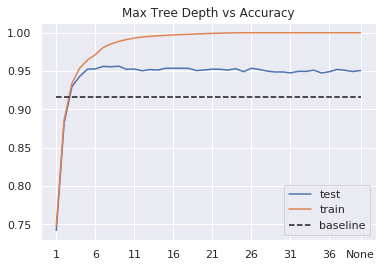

In [10]:
tree_size =  list(range(1,40)) + [None]
test_acc = [ ]
train_acc = [ ]

for s in tree_size:
    dtc = DecisionTreeClassifier(max_depth = s)
    tt_acc, tr_acc = k_fold_evaluate(dtc,folds,accuracy_score)
    
    if(tt_acc > best_result['Decision Tree']):
        best_result['Decision Tree'] = tt_acc
        best_model['Decision Tree'] = dtc
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot([str(x) for x in range(1,40)]+["None"],test_acc, label='test')
plt.plot([str(x) for x in range(1,40)]+["None"],train_acc, label='train')
plt.plot([str(x) for x in range(1,40)]+["None"],[baseline for _ in range(1,41)],'k--', label='baseline')

plt.title("Max Tree Depth vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.xticks([str(x) for x in range(1,40,5)]+["None"])
plt.show()

## Support Vector Machines

In [11]:
svc = SVC(probability=True)

mean_acc,_ = k_fold_evaluate(svc,folds,accuracy_score)

best_model['SVM'] = svc
best_result['SVM'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9350262321732064


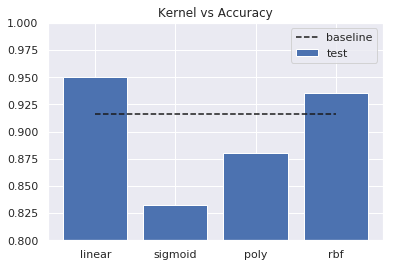

In [12]:
kernels = ['linear','sigmoid','poly','rbf']
test_acc = []

for kr in kernels:
    svc = SVC(kernel = kr,probability=True)
    tt_acc, _ = k_fold_evaluate(svc,folds,accuracy_score)
    
    if(tt_acc > best_result['SVM']):
        best_result['SVM'] = tt_acc
        best_model['SVM'] = svc
    
    test_acc.append(tt_acc)
    
plt.bar(kernels,test_acc,label='test')
plt.plot(kernels,[baseline for _ in range(0,len(kernels))],'k--', label='baseline')
plt.title("Kernel vs Accuracy")
plt.gca().legend(('baseline','test'))
plt.ylim((0.8,1.0))
plt.show()

## KNN Classifier

In [13]:
knn = KNeighborsClassifier()

mean_acc,_ = k_fold_evaluate(knn,folds,accuracy_score)

best_model['KNN'] = knn
best_result['KNN'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.8915818739377818


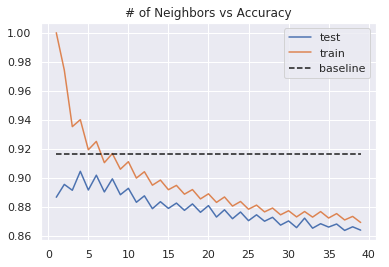

In [14]:
n_neigh =  list(range(1,40))
test_acc = [ ]
train_acc = [ ]
for n in n_neigh:
    knn = KNeighborsClassifier(n_neighbors=n)
    tt_acc, tr_acc = k_fold_evaluate(knn,folds,accuracy_score)
    
    if(tt_acc > best_result['KNN']):
        best_result['KNN'] = tt_acc
        best_model['KNN'] = knn
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_neigh,test_acc, label='test')
plt.plot(n_neigh,train_acc, label='train')
plt.plot(n_neigh,[baseline for _ in n_neigh],'k--', label='baseline')
plt.title("# of Neighbors vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

## Random Forest

In [16]:
rfc = RandomForestClassifier()

mean_acc,_ = k_fold_evaluate(rfc,folds,accuracy_score)

best_model['Random Forest'] = rfc
best_result['Random Forest'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9602078253158945


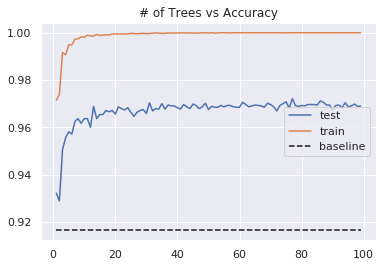

In [17]:
n_trees =  list(range(1,100))
test_acc = [ ]
train_acc = [ ]
for s in n_trees:
    rfc = RandomForestClassifier(n_estimators = s)
    tt_acc, tr_acc = k_fold_evaluate(rfc,folds,accuracy_score)
    
    if(tt_acc > best_result['Random Forest']):
        best_result['Random Forest'] = tt_acc
        best_model['Random Forest'] = rfc
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_trees,test_acc, label='test')
plt.plot(n_trees,train_acc, label='train')
plt.plot(n_trees,[baseline for _ in n_trees],'k--', label='baseline')
plt.title("# of Trees vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

## Gradient Boosting

In [18]:
gbc = GradientBoostingClassifier()

mean_acc,_ = k_fold_evaluate(gbc,folds,accuracy_score)

best_model['Gradient Bosting'] = gbc
best_result['Gradient Bosting'] = mean_acc

print("Mean accuracy: ",mean_acc)

Mean accuracy:  0.9703949604670067


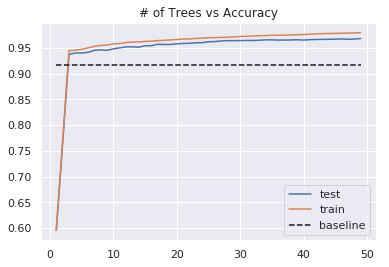

In [19]:
n_trees =  list(range(1,50))
test_acc = [ ]
train_acc = [ ]
for s in n_trees:
    gbc = GradientBoostingClassifier(n_estimators = s)
    tt_acc, tr_acc = k_fold_evaluate(gbc,folds,accuracy_score)
    
    if(tt_acc > best_result['Gradient Bosting']):
        best_result['Gradient Bosting'] = tt_acc
        best_model['Gradient Bosting'] = gbc    
    
    train_acc.append(tr_acc)
    test_acc.append(tt_acc)
    
plt.plot(n_trees,test_acc, label='test')
plt.plot(n_trees,train_acc, label='train')
plt.plot(n_trees,[baseline for _ in n_trees],'k--', label='baseline')
plt.title("# of Trees vs Accuracy")
plt.gca().legend(('test','train','baseline'))
plt.show()

## Results

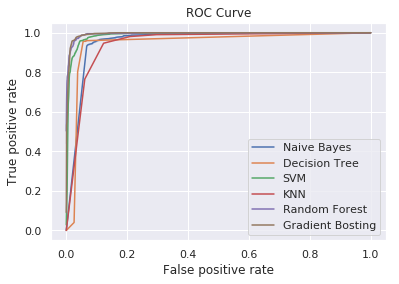

In [21]:
results = pd.DataFrame(columns=['accuracy','recall','f1','auc'])
rocs = {}

for key, model in best_model.items():
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)

    pred = model.predict(X_test)
    probs = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(y_test, probs)

    sns.lineplot(fpr,tpr,label=key)

    recall = recall_score(y_test,pred)
    acc = accuracy_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = auc(fpr, tpr)

    results = results.append(pd.Series(
                             {"accuracy": acc,
                              "recall": recall,
                              "f1": f1,
                              "auc": roc_auc},name=key))
        
plt.ylabel("True positive rate")
plt.xlabel("False positive rate")
plt.title("ROC Curve")
plt.show()

,accuracy,recall,f1,auc
Naive Bayes,0.906470,0.969502,0.892171,0.957482
Decision Tree,0.949391,0.956661,0.937844,0.946786
SVM,0.945548,0.969502,0.934261,0.988309
KNN,0.905189,0.947030,0.888554,0.945843
Random Forest,0.967329,0.963082,0.959233,0.995114
Gradient Bosting,0.971172,0.975923,0.964314,0.994928


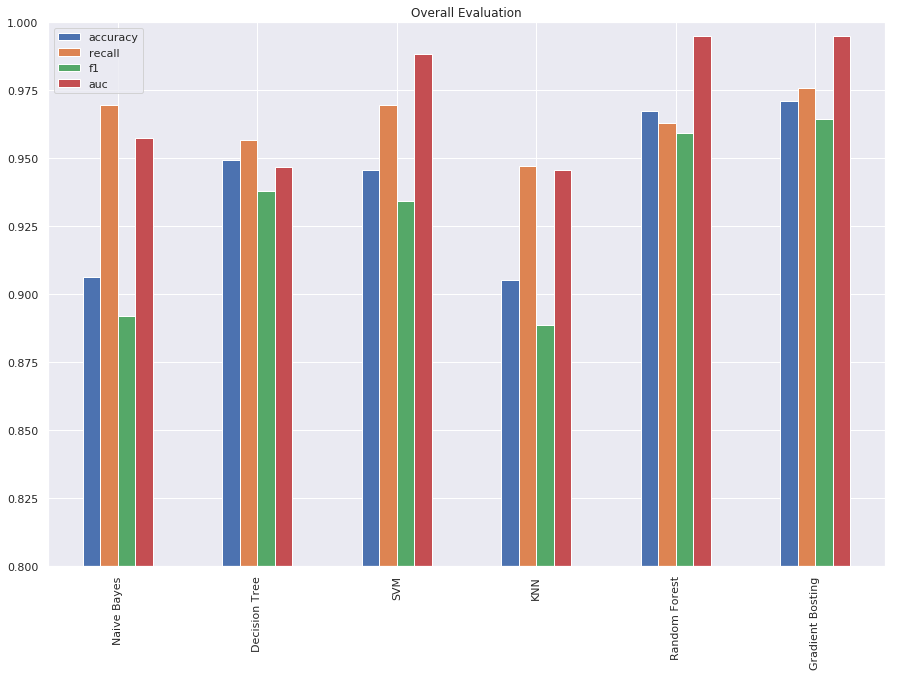

In [22]:
sns.set(rc={'figure.figsize':(15,10)})

display(results)

results.plot(y=['accuracy','recall','f1','auc'], 
             kind='bar',ylim=(0.8,1.0),
             title='Overall Evaluation')

plt.show()

## Conclusions